In [1]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
%pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder('./colored_images', transform=transform)

class_names = dataset.classes
print(f"Labels: {class_names}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=False)

Labels: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [5]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )

        self.sigmoid_channel = nn.Sigmoid()

        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x))
        max = self.shared_MLP(self.max_pool(x))
        x = x * self.sigmoid_channel(avg + max)

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial

In [36]:
class CBAM_DenseNet121_LSTM(nn.Module):
    def __init__(self, lstm_hidden_size=129, num_classes=5):
        super().__init__()

        base = models.densenet121(pretrained=True)
        self.backbone = base.features
        self.feature_extractor = nn.Sequential(
            self.backbone,
            nn.AdaptiveAvgPool2d((7, 7)),
            CBAM(1024)
        )

        self.lstm = nn.LSTM(input_size=49, hidden_size=lstm_hidden_size, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), 1024, -1)
        
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        
        return self.fc(out)


In [7]:
model = CBAM_DenseNet121_LSTM(num_classes=len(dataset.classes)).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
correct = 0
total = 0

for epoch in range(300):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(out, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/300], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/300], Loss: 0.8731, Accuracy: 69.25%
Epoch [2/300], Loss: 0.7317, Accuracy: 71.43%
Epoch [3/300], Loss: 0.6793, Accuracy: 72.93%
Epoch [4/300], Loss: 0.6163, Accuracy: 74.10%
Epoch [5/300], Loss: 0.5846, Accuracy: 74.85%
Epoch [6/300], Loss: 0.5463, Accuracy: 75.51%
Epoch [7/300], Loss: 0.5132, Accuracy: 76.30%
Epoch [8/300], Loss: 0.5091, Accuracy: 76.74%
Epoch [9/300], Loss: 0.4543, Accuracy: 77.36%
Epoch [10/300], Loss: 0.4323, Accuracy: 77.98%
Epoch [11/300], Loss: 0.4046, Accuracy: 78.55%
Epoch [12/300], Loss: 0.3676, Accuracy: 79.23%
Epoch [13/300], Loss: 0.3700, Accuracy: 79.73%
Epoch [14/300], Loss: 0.3625, Accuracy: 80.22%
Epoch [15/300], Loss: 0.3080, Accuracy: 80.74%
Epoch [16/300], Loss: 0.2828, Accuracy: 81.28%
Epoch [17/300], Loss: 0.2714, Accuracy: 81.80%
Epoch [18/300], Loss: 0.2359, Accuracy: 82.28%
Epoch [19/300], Loss: 0.2193, Accuracy: 82.79%
Epoch [20/300], Loss: 0.1726, Accuracy: 83.35%
Epoch [21/300], Loss: 0.1745, Accuracy: 83.84%
Epoch [22/300], Loss: 

In [9]:
torch.save(model.state_dict(), "densenet121CBAM_lstm.pt")

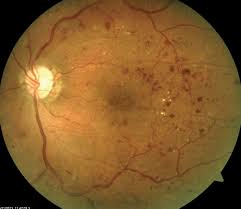


📷 Image: /home/john/Developer/diabetic-retinopathy/images.jpeg
✅ Predicted Class: Moderate

📊 Confidence per class:
  Mild           : 0.00%
  Moderate       : 99.99%
  No_DR          : 0.00%
  Proliferate_DR : 0.01%
  Severe         : 0.00%


In [27]:
from PIL import Image
import torch
from torchvision import transforms
from tkinter import filedialog
from IPython.display import Image as I, display
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # If not pretrained, otherwise use ImageNet stats
])

def load_image():
    image_path = filedialog.askopenfilename(title="Select an image",
                                            filetypes=[("Image Files", "*.jpg *.png *.jpeg")])
    if not image_path:
        print("No image selected.")
        return None, None
    
    display(I(filename=image_path, width=224, height=224))
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    return img_tensor, image_path

# === Inference with confidence display ===
model.eval()
with torch.no_grad():
    img_tensor, path = load_image()
    if img_tensor is not None:
        output = model(img_tensor)                     # raw logits
        probs = F.softmax(output, dim=1)[0]            # softmax → probabilities
        _, predicted = torch.max(probs, dim=0)

        class_names = dataset.classes
        print(f"\n📷 Image: {path}")
        print(f"✅ Predicted Class: {class_names[predicted.item()]}\n")

        print("📊 Confidence per class:")
        for i, prob in enumerate(probs):
            print(f"  {class_names[i]:<15}: {prob.item()*100:.2f}%")


In [30]:
%pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [38]:
import cv2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # If not pretrained, otherwise use ImageNet stats
])

def load_image():
    image_path = filedialog.askopenfilename(
        title="Select an image",
        filetypes=[("Image Files", "*.jpg *.png *.jpeg")]
    )
    if not image_path:
        print("No image selected.")
        return None, None
    
    display(I(filename=image_path, width=224, height=224))
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor, image_path

def generate_gradcam(model, img_tensor, class_names):
    model.eval()

    # Hook containers
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Hook to DenseNet last conv layer (norm5 in DenseNet121)
    target_layer = model.backbone.norm5
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    class_label = class_names[pred_class]

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Unhook
    handle_f.remove()
    handle_b.remove()

    # Compute Grad-CAM
    grads = gradients[0]              # shape: [B, C, H, W]
    acts = activations[0]            # shape: [B, C, H, W]
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])  # [C]

    # Weight activations
    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    # Create heatmap
    heatmap = torch.mean(acts, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    return heatmap, class_label

def overlay_gradcam(heatmap, image_path, alpha=0.5):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    img = np.array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CBAM_DenseNet121_LSTM(num_classes=len(dataset.classes)).to(device)
model.load_state_dict(torch.load("densenet121CBAM_lstm.pt", map_location=device))  # optional
model.eval()

class_names = dataset.classes

# Load and classify
img_tensor, path = load_image()
if img_tensor is not None:
    with torch.no_grad():
        heatmap, predicted_label = generate_gradcam(model, img_tensor, class_names)
        print(f"✅ Predicted class: {predicted_label}")
        overlay_gradcam(heatmap, path)


RuntimeError: Error(s) in loading state_dict for CBAM_DenseNet121_LSTM:
	Missing key(s) in state_dict: "backbone.conv0.weight", "backbone.norm0.weight", "backbone.norm0.bias", "backbone.norm0.running_mean", "backbone.norm0.running_var", "backbone.denseblock1.denselayer1.norm1.weight", "backbone.denseblock1.denselayer1.norm1.bias", "backbone.denseblock1.denselayer1.norm1.running_mean", "backbone.denseblock1.denselayer1.norm1.running_var", "backbone.denseblock1.denselayer1.conv1.weight", "backbone.denseblock1.denselayer1.norm2.weight", "backbone.denseblock1.denselayer1.norm2.bias", "backbone.denseblock1.denselayer1.norm2.running_mean", "backbone.denseblock1.denselayer1.norm2.running_var", "backbone.denseblock1.denselayer1.conv2.weight", "backbone.denseblock1.denselayer2.norm1.weight", "backbone.denseblock1.denselayer2.norm1.bias", "backbone.denseblock1.denselayer2.norm1.running_mean", "backbone.denseblock1.denselayer2.norm1.running_var", "backbone.denseblock1.denselayer2.conv1.weight", "backbone.denseblock1.denselayer2.norm2.weight", "backbone.denseblock1.denselayer2.norm2.bias", "backbone.denseblock1.denselayer2.norm2.running_mean", "backbone.denseblock1.denselayer2.norm2.running_var", "backbone.denseblock1.denselayer2.conv2.weight", "backbone.denseblock1.denselayer3.norm1.weight", "backbone.denseblock1.denselayer3.norm1.bias", "backbone.denseblock1.denselayer3.norm1.running_mean", "backbone.denseblock1.denselayer3.norm1.running_var", "backbone.denseblock1.denselayer3.conv1.weight", "backbone.denseblock1.denselayer3.norm2.weight", "backbone.denseblock1.denselayer3.norm2.bias", "backbone.denseblock1.denselayer3.norm2.running_mean", "backbone.denseblock1.denselayer3.norm2.running_var", "backbone.denseblock1.denselayer3.conv2.weight", "backbone.denseblock1.denselayer4.norm1.weight", "backbone.denseblock1.denselayer4.norm1.bias", "backbone.denseblock1.denselayer4.norm1.running_mean", "backbone.denseblock1.denselayer4.norm1.running_var", "backbone.denseblock1.denselayer4.conv1.weight", "backbone.denseblock1.denselayer4.norm2.weight", "backbone.denseblock1.denselayer4.norm2.bias", "backbone.denseblock1.denselayer4.norm2.running_mean", "backbone.denseblock1.denselayer4.norm2.running_var", "backbone.denseblock1.denselayer4.conv2.weight", "backbone.denseblock1.denselayer5.norm1.weight", "backbone.denseblock1.denselayer5.norm1.bias", "backbone.denseblock1.denselayer5.norm1.running_mean", "backbone.denseblock1.denselayer5.norm1.running_var", "backbone.denseblock1.denselayer5.conv1.weight", "backbone.denseblock1.denselayer5.norm2.weight", "backbone.denseblock1.denselayer5.norm2.bias", "backbone.denseblock1.denselayer5.norm2.running_mean", "backbone.denseblock1.denselayer5.norm2.running_var", "backbone.denseblock1.denselayer5.conv2.weight", "backbone.denseblock1.denselayer6.norm1.weight", "backbone.denseblock1.denselayer6.norm1.bias", "backbone.denseblock1.denselayer6.norm1.running_mean", "backbone.denseblock1.denselayer6.norm1.running_var", "backbone.denseblock1.denselayer6.conv1.weight", "backbone.denseblock1.denselayer6.norm2.weight", "backbone.denseblock1.denselayer6.norm2.bias", "backbone.denseblock1.denselayer6.norm2.running_mean", "backbone.denseblock1.denselayer6.norm2.running_var", "backbone.denseblock1.denselayer6.conv2.weight", "backbone.transition1.norm.weight", "backbone.transition1.norm.bias", "backbone.transition1.norm.running_mean", "backbone.transition1.norm.running_var", "backbone.transition1.conv.weight", "backbone.denseblock2.denselayer1.norm1.weight", "backbone.denseblock2.denselayer1.norm1.bias", "backbone.denseblock2.denselayer1.norm1.running_mean", "backbone.denseblock2.denselayer1.norm1.running_var", "backbone.denseblock2.denselayer1.conv1.weight", "backbone.denseblock2.denselayer1.norm2.weight", "backbone.denseblock2.denselayer1.norm2.bias", "backbone.denseblock2.denselayer1.norm2.running_mean", "backbone.denseblock2.denselayer1.norm2.running_var", "backbone.denseblock2.denselayer1.conv2.weight", "backbone.denseblock2.denselayer2.norm1.weight", "backbone.denseblock2.denselayer2.norm1.bias", "backbone.denseblock2.denselayer2.norm1.running_mean", "backbone.denseblock2.denselayer2.norm1.running_var", "backbone.denseblock2.denselayer2.conv1.weight", "backbone.denseblock2.denselayer2.norm2.weight", "backbone.denseblock2.denselayer2.norm2.bias", "backbone.denseblock2.denselayer2.norm2.running_mean", "backbone.denseblock2.denselayer2.norm2.running_var", "backbone.denseblock2.denselayer2.conv2.weight", "backbone.denseblock2.denselayer3.norm1.weight", "backbone.denseblock2.denselayer3.norm1.bias", "backbone.denseblock2.denselayer3.norm1.running_mean", "backbone.denseblock2.denselayer3.norm1.running_var", "backbone.denseblock2.denselayer3.conv1.weight", "backbone.denseblock2.denselayer3.norm2.weight", "backbone.denseblock2.denselayer3.norm2.bias", "backbone.denseblock2.denselayer3.norm2.running_mean", "backbone.denseblock2.denselayer3.norm2.running_var", "backbone.denseblock2.denselayer3.conv2.weight", "backbone.denseblock2.denselayer4.norm1.weight", "backbone.denseblock2.denselayer4.norm1.bias", "backbone.denseblock2.denselayer4.norm1.running_mean", "backbone.denseblock2.denselayer4.norm1.running_var", "backbone.denseblock2.denselayer4.conv1.weight", "backbone.denseblock2.denselayer4.norm2.weight", "backbone.denseblock2.denselayer4.norm2.bias", "backbone.denseblock2.denselayer4.norm2.running_mean", "backbone.denseblock2.denselayer4.norm2.running_var", "backbone.denseblock2.denselayer4.conv2.weight", "backbone.denseblock2.denselayer5.norm1.weight", "backbone.denseblock2.denselayer5.norm1.bias", "backbone.denseblock2.denselayer5.norm1.running_mean", "backbone.denseblock2.denselayer5.norm1.running_var", "backbone.denseblock2.denselayer5.conv1.weight", "backbone.denseblock2.denselayer5.norm2.weight", "backbone.denseblock2.denselayer5.norm2.bias", "backbone.denseblock2.denselayer5.norm2.running_mean", "backbone.denseblock2.denselayer5.norm2.running_var", "backbone.denseblock2.denselayer5.conv2.weight", "backbone.denseblock2.denselayer6.norm1.weight", "backbone.denseblock2.denselayer6.norm1.bias", "backbone.denseblock2.denselayer6.norm1.running_mean", "backbone.denseblock2.denselayer6.norm1.running_var", "backbone.denseblock2.denselayer6.conv1.weight", "backbone.denseblock2.denselayer6.norm2.weight", "backbone.denseblock2.denselayer6.norm2.bias", "backbone.denseblock2.denselayer6.norm2.running_mean", "backbone.denseblock2.denselayer6.norm2.running_var", "backbone.denseblock2.denselayer6.conv2.weight", "backbone.denseblock2.denselayer7.norm1.weight", "backbone.denseblock2.denselayer7.norm1.bias", "backbone.denseblock2.denselayer7.norm1.running_mean", "backbone.denseblock2.denselayer7.norm1.running_var", "backbone.denseblock2.denselayer7.conv1.weight", "backbone.denseblock2.denselayer7.norm2.weight", "backbone.denseblock2.denselayer7.norm2.bias", "backbone.denseblock2.denselayer7.norm2.running_mean", "backbone.denseblock2.denselayer7.norm2.running_var", "backbone.denseblock2.denselayer7.conv2.weight", "backbone.denseblock2.denselayer8.norm1.weight", "backbone.denseblock2.denselayer8.norm1.bias", "backbone.denseblock2.denselayer8.norm1.running_mean", "backbone.denseblock2.denselayer8.norm1.running_var", "backbone.denseblock2.denselayer8.conv1.weight", "backbone.denseblock2.denselayer8.norm2.weight", "backbone.denseblock2.denselayer8.norm2.bias", "backbone.denseblock2.denselayer8.norm2.running_mean", "backbone.denseblock2.denselayer8.norm2.running_var", "backbone.denseblock2.denselayer8.conv2.weight", "backbone.denseblock2.denselayer9.norm1.weight", "backbone.denseblock2.denselayer9.norm1.bias", "backbone.denseblock2.denselayer9.norm1.running_mean", "backbone.denseblock2.denselayer9.norm1.running_var", "backbone.denseblock2.denselayer9.conv1.weight", "backbone.denseblock2.denselayer9.norm2.weight", "backbone.denseblock2.denselayer9.norm2.bias", "backbone.denseblock2.denselayer9.norm2.running_mean", "backbone.denseblock2.denselayer9.norm2.running_var", "backbone.denseblock2.denselayer9.conv2.weight", "backbone.denseblock2.denselayer10.norm1.weight", "backbone.denseblock2.denselayer10.norm1.bias", "backbone.denseblock2.denselayer10.norm1.running_mean", "backbone.denseblock2.denselayer10.norm1.running_var", "backbone.denseblock2.denselayer10.conv1.weight", "backbone.denseblock2.denselayer10.norm2.weight", "backbone.denseblock2.denselayer10.norm2.bias", "backbone.denseblock2.denselayer10.norm2.running_mean", "backbone.denseblock2.denselayer10.norm2.running_var", "backbone.denseblock2.denselayer10.conv2.weight", "backbone.denseblock2.denselayer11.norm1.weight", "backbone.denseblock2.denselayer11.norm1.bias", "backbone.denseblock2.denselayer11.norm1.running_mean", "backbone.denseblock2.denselayer11.norm1.running_var", "backbone.denseblock2.denselayer11.conv1.weight", "backbone.denseblock2.denselayer11.norm2.weight", "backbone.denseblock2.denselayer11.norm2.bias", "backbone.denseblock2.denselayer11.norm2.running_mean", "backbone.denseblock2.denselayer11.norm2.running_var", "backbone.denseblock2.denselayer11.conv2.weight", "backbone.denseblock2.denselayer12.norm1.weight", "backbone.denseblock2.denselayer12.norm1.bias", "backbone.denseblock2.denselayer12.norm1.running_mean", "backbone.denseblock2.denselayer12.norm1.running_var", "backbone.denseblock2.denselayer12.conv1.weight", "backbone.denseblock2.denselayer12.norm2.weight", "backbone.denseblock2.denselayer12.norm2.bias", "backbone.denseblock2.denselayer12.norm2.running_mean", "backbone.denseblock2.denselayer12.norm2.running_var", "backbone.denseblock2.denselayer12.conv2.weight", "backbone.transition2.norm.weight", "backbone.transition2.norm.bias", "backbone.transition2.norm.running_mean", "backbone.transition2.norm.running_var", "backbone.transition2.conv.weight", "backbone.denseblock3.denselayer1.norm1.weight", "backbone.denseblock3.denselayer1.norm1.bias", "backbone.denseblock3.denselayer1.norm1.running_mean", "backbone.denseblock3.denselayer1.norm1.running_var", "backbone.denseblock3.denselayer1.conv1.weight", "backbone.denseblock3.denselayer1.norm2.weight", "backbone.denseblock3.denselayer1.norm2.bias", "backbone.denseblock3.denselayer1.norm2.running_mean", "backbone.denseblock3.denselayer1.norm2.running_var", "backbone.denseblock3.denselayer1.conv2.weight", "backbone.denseblock3.denselayer2.norm1.weight", "backbone.denseblock3.denselayer2.norm1.bias", "backbone.denseblock3.denselayer2.norm1.running_mean", "backbone.denseblock3.denselayer2.norm1.running_var", "backbone.denseblock3.denselayer2.conv1.weight", "backbone.denseblock3.denselayer2.norm2.weight", "backbone.denseblock3.denselayer2.norm2.bias", "backbone.denseblock3.denselayer2.norm2.running_mean", "backbone.denseblock3.denselayer2.norm2.running_var", "backbone.denseblock3.denselayer2.conv2.weight", "backbone.denseblock3.denselayer3.norm1.weight", "backbone.denseblock3.denselayer3.norm1.bias", "backbone.denseblock3.denselayer3.norm1.running_mean", "backbone.denseblock3.denselayer3.norm1.running_var", "backbone.denseblock3.denselayer3.conv1.weight", "backbone.denseblock3.denselayer3.norm2.weight", "backbone.denseblock3.denselayer3.norm2.bias", "backbone.denseblock3.denselayer3.norm2.running_mean", "backbone.denseblock3.denselayer3.norm2.running_var", "backbone.denseblock3.denselayer3.conv2.weight", "backbone.denseblock3.denselayer4.norm1.weight", "backbone.denseblock3.denselayer4.norm1.bias", "backbone.denseblock3.denselayer4.norm1.running_mean", "backbone.denseblock3.denselayer4.norm1.running_var", "backbone.denseblock3.denselayer4.conv1.weight", "backbone.denseblock3.denselayer4.norm2.weight", "backbone.denseblock3.denselayer4.norm2.bias", "backbone.denseblock3.denselayer4.norm2.running_mean", "backbone.denseblock3.denselayer4.norm2.running_var", "backbone.denseblock3.denselayer4.conv2.weight", "backbone.denseblock3.denselayer5.norm1.weight", "backbone.denseblock3.denselayer5.norm1.bias", "backbone.denseblock3.denselayer5.norm1.running_mean", "backbone.denseblock3.denselayer5.norm1.running_var", "backbone.denseblock3.denselayer5.conv1.weight", "backbone.denseblock3.denselayer5.norm2.weight", "backbone.denseblock3.denselayer5.norm2.bias", "backbone.denseblock3.denselayer5.norm2.running_mean", "backbone.denseblock3.denselayer5.norm2.running_var", "backbone.denseblock3.denselayer5.conv2.weight", "backbone.denseblock3.denselayer6.norm1.weight", "backbone.denseblock3.denselayer6.norm1.bias", "backbone.denseblock3.denselayer6.norm1.running_mean", "backbone.denseblock3.denselayer6.norm1.running_var", "backbone.denseblock3.denselayer6.conv1.weight", "backbone.denseblock3.denselayer6.norm2.weight", "backbone.denseblock3.denselayer6.norm2.bias", "backbone.denseblock3.denselayer6.norm2.running_mean", "backbone.denseblock3.denselayer6.norm2.running_var", "backbone.denseblock3.denselayer6.conv2.weight", "backbone.denseblock3.denselayer7.norm1.weight", "backbone.denseblock3.denselayer7.norm1.bias", "backbone.denseblock3.denselayer7.norm1.running_mean", "backbone.denseblock3.denselayer7.norm1.running_var", "backbone.denseblock3.denselayer7.conv1.weight", "backbone.denseblock3.denselayer7.norm2.weight", "backbone.denseblock3.denselayer7.norm2.bias", "backbone.denseblock3.denselayer7.norm2.running_mean", "backbone.denseblock3.denselayer7.norm2.running_var", "backbone.denseblock3.denselayer7.conv2.weight", "backbone.denseblock3.denselayer8.norm1.weight", "backbone.denseblock3.denselayer8.norm1.bias", "backbone.denseblock3.denselayer8.norm1.running_mean", "backbone.denseblock3.denselayer8.norm1.running_var", "backbone.denseblock3.denselayer8.conv1.weight", "backbone.denseblock3.denselayer8.norm2.weight", "backbone.denseblock3.denselayer8.norm2.bias", "backbone.denseblock3.denselayer8.norm2.running_mean", "backbone.denseblock3.denselayer8.norm2.running_var", "backbone.denseblock3.denselayer8.conv2.weight", "backbone.denseblock3.denselayer9.norm1.weight", "backbone.denseblock3.denselayer9.norm1.bias", "backbone.denseblock3.denselayer9.norm1.running_mean", "backbone.denseblock3.denselayer9.norm1.running_var", "backbone.denseblock3.denselayer9.conv1.weight", "backbone.denseblock3.denselayer9.norm2.weight", "backbone.denseblock3.denselayer9.norm2.bias", "backbone.denseblock3.denselayer9.norm2.running_mean", "backbone.denseblock3.denselayer9.norm2.running_var", "backbone.denseblock3.denselayer9.conv2.weight", "backbone.denseblock3.denselayer10.norm1.weight", "backbone.denseblock3.denselayer10.norm1.bias", "backbone.denseblock3.denselayer10.norm1.running_mean", "backbone.denseblock3.denselayer10.norm1.running_var", "backbone.denseblock3.denselayer10.conv1.weight", "backbone.denseblock3.denselayer10.norm2.weight", "backbone.denseblock3.denselayer10.norm2.bias", "backbone.denseblock3.denselayer10.norm2.running_mean", "backbone.denseblock3.denselayer10.norm2.running_var", "backbone.denseblock3.denselayer10.conv2.weight", "backbone.denseblock3.denselayer11.norm1.weight", "backbone.denseblock3.denselayer11.norm1.bias", "backbone.denseblock3.denselayer11.norm1.running_mean", "backbone.denseblock3.denselayer11.norm1.running_var", "backbone.denseblock3.denselayer11.conv1.weight", "backbone.denseblock3.denselayer11.norm2.weight", "backbone.denseblock3.denselayer11.norm2.bias", "backbone.denseblock3.denselayer11.norm2.running_mean", "backbone.denseblock3.denselayer11.norm2.running_var", "backbone.denseblock3.denselayer11.conv2.weight", "backbone.denseblock3.denselayer12.norm1.weight", "backbone.denseblock3.denselayer12.norm1.bias", "backbone.denseblock3.denselayer12.norm1.running_mean", "backbone.denseblock3.denselayer12.norm1.running_var", "backbone.denseblock3.denselayer12.conv1.weight", "backbone.denseblock3.denselayer12.norm2.weight", "backbone.denseblock3.denselayer12.norm2.bias", "backbone.denseblock3.denselayer12.norm2.running_mean", "backbone.denseblock3.denselayer12.norm2.running_var", "backbone.denseblock3.denselayer12.conv2.weight", "backbone.denseblock3.denselayer13.norm1.weight", "backbone.denseblock3.denselayer13.norm1.bias", "backbone.denseblock3.denselayer13.norm1.running_mean", "backbone.denseblock3.denselayer13.norm1.running_var", "backbone.denseblock3.denselayer13.conv1.weight", "backbone.denseblock3.denselayer13.norm2.weight", "backbone.denseblock3.denselayer13.norm2.bias", "backbone.denseblock3.denselayer13.norm2.running_mean", "backbone.denseblock3.denselayer13.norm2.running_var", "backbone.denseblock3.denselayer13.conv2.weight", "backbone.denseblock3.denselayer14.norm1.weight", "backbone.denseblock3.denselayer14.norm1.bias", "backbone.denseblock3.denselayer14.norm1.running_mean", "backbone.denseblock3.denselayer14.norm1.running_var", "backbone.denseblock3.denselayer14.conv1.weight", "backbone.denseblock3.denselayer14.norm2.weight", "backbone.denseblock3.denselayer14.norm2.bias", "backbone.denseblock3.denselayer14.norm2.running_mean", "backbone.denseblock3.denselayer14.norm2.running_var", "backbone.denseblock3.denselayer14.conv2.weight", "backbone.denseblock3.denselayer15.norm1.weight", "backbone.denseblock3.denselayer15.norm1.bias", "backbone.denseblock3.denselayer15.norm1.running_mean", "backbone.denseblock3.denselayer15.norm1.running_var", "backbone.denseblock3.denselayer15.conv1.weight", "backbone.denseblock3.denselayer15.norm2.weight", "backbone.denseblock3.denselayer15.norm2.bias", "backbone.denseblock3.denselayer15.norm2.running_mean", "backbone.denseblock3.denselayer15.norm2.running_var", "backbone.denseblock3.denselayer15.conv2.weight", "backbone.denseblock3.denselayer16.norm1.weight", "backbone.denseblock3.denselayer16.norm1.bias", "backbone.denseblock3.denselayer16.norm1.running_mean", "backbone.denseblock3.denselayer16.norm1.running_var", "backbone.denseblock3.denselayer16.conv1.weight", "backbone.denseblock3.denselayer16.norm2.weight", "backbone.denseblock3.denselayer16.norm2.bias", "backbone.denseblock3.denselayer16.norm2.running_mean", "backbone.denseblock3.denselayer16.norm2.running_var", "backbone.denseblock3.denselayer16.conv2.weight", "backbone.denseblock3.denselayer17.norm1.weight", "backbone.denseblock3.denselayer17.norm1.bias", "backbone.denseblock3.denselayer17.norm1.running_mean", "backbone.denseblock3.denselayer17.norm1.running_var", "backbone.denseblock3.denselayer17.conv1.weight", "backbone.denseblock3.denselayer17.norm2.weight", "backbone.denseblock3.denselayer17.norm2.bias", "backbone.denseblock3.denselayer17.norm2.running_mean", "backbone.denseblock3.denselayer17.norm2.running_var", "backbone.denseblock3.denselayer17.conv2.weight", "backbone.denseblock3.denselayer18.norm1.weight", "backbone.denseblock3.denselayer18.norm1.bias", "backbone.denseblock3.denselayer18.norm1.running_mean", "backbone.denseblock3.denselayer18.norm1.running_var", "backbone.denseblock3.denselayer18.conv1.weight", "backbone.denseblock3.denselayer18.norm2.weight", "backbone.denseblock3.denselayer18.norm2.bias", "backbone.denseblock3.denselayer18.norm2.running_mean", "backbone.denseblock3.denselayer18.norm2.running_var", "backbone.denseblock3.denselayer18.conv2.weight", "backbone.denseblock3.denselayer19.norm1.weight", "backbone.denseblock3.denselayer19.norm1.bias", "backbone.denseblock3.denselayer19.norm1.running_mean", "backbone.denseblock3.denselayer19.norm1.running_var", "backbone.denseblock3.denselayer19.conv1.weight", "backbone.denseblock3.denselayer19.norm2.weight", "backbone.denseblock3.denselayer19.norm2.bias", "backbone.denseblock3.denselayer19.norm2.running_mean", "backbone.denseblock3.denselayer19.norm2.running_var", "backbone.denseblock3.denselayer19.conv2.weight", "backbone.denseblock3.denselayer20.norm1.weight", "backbone.denseblock3.denselayer20.norm1.bias", "backbone.denseblock3.denselayer20.norm1.running_mean", "backbone.denseblock3.denselayer20.norm1.running_var", "backbone.denseblock3.denselayer20.conv1.weight", "backbone.denseblock3.denselayer20.norm2.weight", "backbone.denseblock3.denselayer20.norm2.bias", "backbone.denseblock3.denselayer20.norm2.running_mean", "backbone.denseblock3.denselayer20.norm2.running_var", "backbone.denseblock3.denselayer20.conv2.weight", "backbone.denseblock3.denselayer21.norm1.weight", "backbone.denseblock3.denselayer21.norm1.bias", "backbone.denseblock3.denselayer21.norm1.running_mean", "backbone.denseblock3.denselayer21.norm1.running_var", "backbone.denseblock3.denselayer21.conv1.weight", "backbone.denseblock3.denselayer21.norm2.weight", "backbone.denseblock3.denselayer21.norm2.bias", "backbone.denseblock3.denselayer21.norm2.running_mean", "backbone.denseblock3.denselayer21.norm2.running_var", "backbone.denseblock3.denselayer21.conv2.weight", "backbone.denseblock3.denselayer22.norm1.weight", "backbone.denseblock3.denselayer22.norm1.bias", "backbone.denseblock3.denselayer22.norm1.running_mean", "backbone.denseblock3.denselayer22.norm1.running_var", "backbone.denseblock3.denselayer22.conv1.weight", "backbone.denseblock3.denselayer22.norm2.weight", "backbone.denseblock3.denselayer22.norm2.bias", "backbone.denseblock3.denselayer22.norm2.running_mean", "backbone.denseblock3.denselayer22.norm2.running_var", "backbone.denseblock3.denselayer22.conv2.weight", "backbone.denseblock3.denselayer23.norm1.weight", "backbone.denseblock3.denselayer23.norm1.bias", "backbone.denseblock3.denselayer23.norm1.running_mean", "backbone.denseblock3.denselayer23.norm1.running_var", "backbone.denseblock3.denselayer23.conv1.weight", "backbone.denseblock3.denselayer23.norm2.weight", "backbone.denseblock3.denselayer23.norm2.bias", "backbone.denseblock3.denselayer23.norm2.running_mean", "backbone.denseblock3.denselayer23.norm2.running_var", "backbone.denseblock3.denselayer23.conv2.weight", "backbone.denseblock3.denselayer24.norm1.weight", "backbone.denseblock3.denselayer24.norm1.bias", "backbone.denseblock3.denselayer24.norm1.running_mean", "backbone.denseblock3.denselayer24.norm1.running_var", "backbone.denseblock3.denselayer24.conv1.weight", "backbone.denseblock3.denselayer24.norm2.weight", "backbone.denseblock3.denselayer24.norm2.bias", "backbone.denseblock3.denselayer24.norm2.running_mean", "backbone.denseblock3.denselayer24.norm2.running_var", "backbone.denseblock3.denselayer24.conv2.weight", "backbone.transition3.norm.weight", "backbone.transition3.norm.bias", "backbone.transition3.norm.running_mean", "backbone.transition3.norm.running_var", "backbone.transition3.conv.weight", "backbone.denseblock4.denselayer1.norm1.weight", "backbone.denseblock4.denselayer1.norm1.bias", "backbone.denseblock4.denselayer1.norm1.running_mean", "backbone.denseblock4.denselayer1.norm1.running_var", "backbone.denseblock4.denselayer1.conv1.weight", "backbone.denseblock4.denselayer1.norm2.weight", "backbone.denseblock4.denselayer1.norm2.bias", "backbone.denseblock4.denselayer1.norm2.running_mean", "backbone.denseblock4.denselayer1.norm2.running_var", "backbone.denseblock4.denselayer1.conv2.weight", "backbone.denseblock4.denselayer2.norm1.weight", "backbone.denseblock4.denselayer2.norm1.bias", "backbone.denseblock4.denselayer2.norm1.running_mean", "backbone.denseblock4.denselayer2.norm1.running_var", "backbone.denseblock4.denselayer2.conv1.weight", "backbone.denseblock4.denselayer2.norm2.weight", "backbone.denseblock4.denselayer2.norm2.bias", "backbone.denseblock4.denselayer2.norm2.running_mean", "backbone.denseblock4.denselayer2.norm2.running_var", "backbone.denseblock4.denselayer2.conv2.weight", "backbone.denseblock4.denselayer3.norm1.weight", "backbone.denseblock4.denselayer3.norm1.bias", "backbone.denseblock4.denselayer3.norm1.running_mean", "backbone.denseblock4.denselayer3.norm1.running_var", "backbone.denseblock4.denselayer3.conv1.weight", "backbone.denseblock4.denselayer3.norm2.weight", "backbone.denseblock4.denselayer3.norm2.bias", "backbone.denseblock4.denselayer3.norm2.running_mean", "backbone.denseblock4.denselayer3.norm2.running_var", "backbone.denseblock4.denselayer3.conv2.weight", "backbone.denseblock4.denselayer4.norm1.weight", "backbone.denseblock4.denselayer4.norm1.bias", "backbone.denseblock4.denselayer4.norm1.running_mean", "backbone.denseblock4.denselayer4.norm1.running_var", "backbone.denseblock4.denselayer4.conv1.weight", "backbone.denseblock4.denselayer4.norm2.weight", "backbone.denseblock4.denselayer4.norm2.bias", "backbone.denseblock4.denselayer4.norm2.running_mean", "backbone.denseblock4.denselayer4.norm2.running_var", "backbone.denseblock4.denselayer4.conv2.weight", "backbone.denseblock4.denselayer5.norm1.weight", "backbone.denseblock4.denselayer5.norm1.bias", "backbone.denseblock4.denselayer5.norm1.running_mean", "backbone.denseblock4.denselayer5.norm1.running_var", "backbone.denseblock4.denselayer5.conv1.weight", "backbone.denseblock4.denselayer5.norm2.weight", "backbone.denseblock4.denselayer5.norm2.bias", "backbone.denseblock4.denselayer5.norm2.running_mean", "backbone.denseblock4.denselayer5.norm2.running_var", "backbone.denseblock4.denselayer5.conv2.weight", "backbone.denseblock4.denselayer6.norm1.weight", "backbone.denseblock4.denselayer6.norm1.bias", "backbone.denseblock4.denselayer6.norm1.running_mean", "backbone.denseblock4.denselayer6.norm1.running_var", "backbone.denseblock4.denselayer6.conv1.weight", "backbone.denseblock4.denselayer6.norm2.weight", "backbone.denseblock4.denselayer6.norm2.bias", "backbone.denseblock4.denselayer6.norm2.running_mean", "backbone.denseblock4.denselayer6.norm2.running_var", "backbone.denseblock4.denselayer6.conv2.weight", "backbone.denseblock4.denselayer7.norm1.weight", "backbone.denseblock4.denselayer7.norm1.bias", "backbone.denseblock4.denselayer7.norm1.running_mean", "backbone.denseblock4.denselayer7.norm1.running_var", "backbone.denseblock4.denselayer7.conv1.weight", "backbone.denseblock4.denselayer7.norm2.weight", "backbone.denseblock4.denselayer7.norm2.bias", "backbone.denseblock4.denselayer7.norm2.running_mean", "backbone.denseblock4.denselayer7.norm2.running_var", "backbone.denseblock4.denselayer7.conv2.weight", "backbone.denseblock4.denselayer8.norm1.weight", "backbone.denseblock4.denselayer8.norm1.bias", "backbone.denseblock4.denselayer8.norm1.running_mean", "backbone.denseblock4.denselayer8.norm1.running_var", "backbone.denseblock4.denselayer8.conv1.weight", "backbone.denseblock4.denselayer8.norm2.weight", "backbone.denseblock4.denselayer8.norm2.bias", "backbone.denseblock4.denselayer8.norm2.running_mean", "backbone.denseblock4.denselayer8.norm2.running_var", "backbone.denseblock4.denselayer8.conv2.weight", "backbone.denseblock4.denselayer9.norm1.weight", "backbone.denseblock4.denselayer9.norm1.bias", "backbone.denseblock4.denselayer9.norm1.running_mean", "backbone.denseblock4.denselayer9.norm1.running_var", "backbone.denseblock4.denselayer9.conv1.weight", "backbone.denseblock4.denselayer9.norm2.weight", "backbone.denseblock4.denselayer9.norm2.bias", "backbone.denseblock4.denselayer9.norm2.running_mean", "backbone.denseblock4.denselayer9.norm2.running_var", "backbone.denseblock4.denselayer9.conv2.weight", "backbone.denseblock4.denselayer10.norm1.weight", "backbone.denseblock4.denselayer10.norm1.bias", "backbone.denseblock4.denselayer10.norm1.running_mean", "backbone.denseblock4.denselayer10.norm1.running_var", "backbone.denseblock4.denselayer10.conv1.weight", "backbone.denseblock4.denselayer10.norm2.weight", "backbone.denseblock4.denselayer10.norm2.bias", "backbone.denseblock4.denselayer10.norm2.running_mean", "backbone.denseblock4.denselayer10.norm2.running_var", "backbone.denseblock4.denselayer10.conv2.weight", "backbone.denseblock4.denselayer11.norm1.weight", "backbone.denseblock4.denselayer11.norm1.bias", "backbone.denseblock4.denselayer11.norm1.running_mean", "backbone.denseblock4.denselayer11.norm1.running_var", "backbone.denseblock4.denselayer11.conv1.weight", "backbone.denseblock4.denselayer11.norm2.weight", "backbone.denseblock4.denselayer11.norm2.bias", "backbone.denseblock4.denselayer11.norm2.running_mean", "backbone.denseblock4.denselayer11.norm2.running_var", "backbone.denseblock4.denselayer11.conv2.weight", "backbone.denseblock4.denselayer12.norm1.weight", "backbone.denseblock4.denselayer12.norm1.bias", "backbone.denseblock4.denselayer12.norm1.running_mean", "backbone.denseblock4.denselayer12.norm1.running_var", "backbone.denseblock4.denselayer12.conv1.weight", "backbone.denseblock4.denselayer12.norm2.weight", "backbone.denseblock4.denselayer12.norm2.bias", "backbone.denseblock4.denselayer12.norm2.running_mean", "backbone.denseblock4.denselayer12.norm2.running_var", "backbone.denseblock4.denselayer12.conv2.weight", "backbone.denseblock4.denselayer13.norm1.weight", "backbone.denseblock4.denselayer13.norm1.bias", "backbone.denseblock4.denselayer13.norm1.running_mean", "backbone.denseblock4.denselayer13.norm1.running_var", "backbone.denseblock4.denselayer13.conv1.weight", "backbone.denseblock4.denselayer13.norm2.weight", "backbone.denseblock4.denselayer13.norm2.bias", "backbone.denseblock4.denselayer13.norm2.running_mean", "backbone.denseblock4.denselayer13.norm2.running_var", "backbone.denseblock4.denselayer13.conv2.weight", "backbone.denseblock4.denselayer14.norm1.weight", "backbone.denseblock4.denselayer14.norm1.bias", "backbone.denseblock4.denselayer14.norm1.running_mean", "backbone.denseblock4.denselayer14.norm1.running_var", "backbone.denseblock4.denselayer14.conv1.weight", "backbone.denseblock4.denselayer14.norm2.weight", "backbone.denseblock4.denselayer14.norm2.bias", "backbone.denseblock4.denselayer14.norm2.running_mean", "backbone.denseblock4.denselayer14.norm2.running_var", "backbone.denseblock4.denselayer14.conv2.weight", "backbone.denseblock4.denselayer15.norm1.weight", "backbone.denseblock4.denselayer15.norm1.bias", "backbone.denseblock4.denselayer15.norm1.running_mean", "backbone.denseblock4.denselayer15.norm1.running_var", "backbone.denseblock4.denselayer15.conv1.weight", "backbone.denseblock4.denselayer15.norm2.weight", "backbone.denseblock4.denselayer15.norm2.bias", "backbone.denseblock4.denselayer15.norm2.running_mean", "backbone.denseblock4.denselayer15.norm2.running_var", "backbone.denseblock4.denselayer15.conv2.weight", "backbone.denseblock4.denselayer16.norm1.weight", "backbone.denseblock4.denselayer16.norm1.bias", "backbone.denseblock4.denselayer16.norm1.running_mean", "backbone.denseblock4.denselayer16.norm1.running_var", "backbone.denseblock4.denselayer16.conv1.weight", "backbone.denseblock4.denselayer16.norm2.weight", "backbone.denseblock4.denselayer16.norm2.bias", "backbone.denseblock4.denselayer16.norm2.running_mean", "backbone.denseblock4.denselayer16.norm2.running_var", "backbone.denseblock4.denselayer16.conv2.weight", "backbone.norm5.weight", "backbone.norm5.bias", "backbone.norm5.running_mean", "backbone.norm5.running_var". 